# This file will evaluate the results from `bilby_pipe` in bulk

## Imports

In [1]:
import numpy as np
import pandas as pd
import bilby
from collections import namedtuple

bilby.core.utils.log.setup_logger(log_level=30)
import os
import bilby.gw.result as bilby_result
from itertools import product
import ast
import scipy
import matplotlib.pyplot as plt
import ligo.skymap.plot.pp as ppplot

/opt/desc/py/lib/python3.12/site-packages/igwn_ligolw/lsctables.py:57: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


## Function definitions

In [2]:
def getMeaningfulColumns(differenceDF):
    cols = []
    for col in differenceDF:
        if differenceDF[col].isna().all():
            continue
        else:
            cols.append(col)
    return cols


def makePostInjDiffPlot(columns, differenceDF, event=False):
    nrows = int(np.ceil((len(columns)) / 5))
    fig, axs = plt.subplots(nrows, 5, figsize=[10, 2 * nrows])
    if type(event) == str:
        fig.suptitle(f"{event} - Injection value for ensemble")
    else:
        fig.suptitle(
            f"Posterior samples - Injection for different parameters of event\n{event.label}"
        )
    for col, ax in zip(columns, axs.flatten()):
        ax.hist(differenceDF[col], histtype="step")
        # ax.grid()
        ax.set_xlabel(col)
        ax.axvline(0, 0, ax.get_ylim()[1], color="red")
        # if not (type(event)==str):
        #     ax.set_title(f"True: {}")
    for ax in axs[:, 0]:
        ax.set_ylabel("Counts / bin")
    fig.tight_layout(pad=2)
    return fig, axs


def getResult(
    path,
    injectionDir="injectionFiles",
    injectionSuffix="_injection.dat",
    verbose=False,
    CBC_type="BBH",
):
    """
    A function to read a path where the bilby_pipe run
    is stored, and return a complete CBCResult object
    """
    parentPath = "/".join(path.split("/")[:-1])
    label = path.split("/")[
        -1
    ]  # The label, taking the form UniformParent,uWeight_aligned_BBH_5
    # Return the final result
    readPath = os.path.join(
        parentPath,
        label,
        "final_result",
        label + "_data0_0_analysis_H1L1V1_result.hdf5",
    )
    if verbose:
        print(f"ReadPath: {readPath}")
    return bilby_result.CBCResult.from_hdf5(readPath)


def getEventsFromPath(path, CBC_type="BBH", verbose=False):
    """
    A function to read all CBC events from a parent catalog directory
    """
    print(f"Reading events from {path}")
    allEvents = []
    eventDirectories = os.listdir(path)
    for event in list(eventDirectories):
        try:
            if event.__contains__(CBC_type):
                allEvents.append(getResult(os.path.join(path, event)))
        except:
            if verbose:
                print(f"Could not open {event}")
            continue
    return allEvents


def readEvents(basePath, catPath, cosmo_ready=False, cosmo_cut=10, types="BBH"):
    """
    Load BBH events from a catalog directory and optionally apply a network-SNR cut.

    This function reads all CBC events from a catalog located
    at ``basePath/catPath`` using ``getEventsFromPath``. If ``cosmo_ready`` is set
    to True, it additionally filters the events based on a network signal-to-noise
    ratio (SNR) threshold constructed from the optimal SNRs in the V1, H1, and L1
    detectors.

    Parameters
    ----------
    basePath : str
        Base directory containing one or more event catalogs.
    catPath : str
        Relative path to the specific catalog directory to read.
    cosmo_ready : bool, optional
        If True, apply a network-SNR cut to select events suitable for cosmological
        analyses. Default is False.
    cosmo_cut : float, optional
        Threshold on the network SNR,
        ``sqrt(SNR_V1^2 + SNR_H1^2 + SNR_L1^2)``,
        used when ``cosmo_ready`` is True. Default is 10.
    types : string, optional
        The type of CBC's to read. Options are `BBH` or `NSBH`.
    Returns
    -------
    allEvents : list
        List of all BBH events read from the specified catalog.
    filteredEvents : list, optional
        List of events passing the network-SNR cut. Only returned if
        ``cosmo_ready`` is True.

    Notes
    -----
    The function prints basic bookkeeping information, including the number of
    events read and (if applicable) the number remaining after SNR filtering.
    """
    t_directory = os.path.join(basePath, catPath)
    print(f"Reading from directory {catPath}")
    allEvents = getEventsFromPath(t_directory, CBC_type=types)
    print(f"Number of events for {catPath}: {len(allEvents)}")

    if cosmo_ready:
        filteredEvents = []
        for ev in allEvents:
            if (
                np.sqrt(
                    ev.injection_parameters["V1_optimal_snr"] ** 2
                    + ev.injection_parameters["H1_optimal_snr"] ** 2
                    + ev.injection_parameters["L1_optimal_snr"] ** 2
                )
                > cosmo_cut
            ):
                filteredEvents.append(ev)
        print(
            f"Number of events for {catPath}, after SNR filtering: {len(filteredEvents)}"
        )
        return allEvents, filteredEvents
    else:
        return allEvents


def makePP_plot(events, fname, keys=None):
    """
    Generate a P–P (probability–probability) plot from a collection of
    bilby result objects.

    This is a thin wrapper around ``bilby.core.result.make_pp_plot`` that
    optionally restricts the plot to a subset of parameter keys.

    Parameters
    ----------
    events : list
        A list of ``bilby.core.result.Result`` objects to include in the
        P–P plot.
    fname : str
        Output filename for the generated plot.
    keys : list of str, optional
        Parameter names to include in the P–P plot. If ``None`` (default),
        all available parameters are used.

    Returns
    -------
    None
        The plot is written to disk at the specified filename.
    """
    if keys == None:
        return bilby.core.result.make_pp_plot(events, filename=fname)
    else:
        return bilby.core.result.make_pp_plot(events, filename=fname, keys=keys)


def inj_rec_plot(
    events,
    qParams=["mass_ratio", "luminosity_distance", "chirp_mass"],
    qLims=[1, 7500, 250],
):
    """
    Create injected–vs–recovered scatter plots for selected parameters.

    For each parameter, this function compares the injected (true) value
    to the recovered value (taken as the posterior median) across a set
    of events. Points are colored by the log10 of the network SNR, computed
    from the optimal SNRs of the H1, L1, and V1 detectors.

    Parameters
    ----------
    events : list
        A list of event objects (e.g., ``bilby.core.result.Result``-like)
        containing ``injection_parameters``, ``posterior``, and ``label``
        attributes.
    qParams : list of str, optional
        Names of parameters to plot. Each parameter must be present in
        both ``ev.injection_parameters`` and ``ev.posterior``.
        Default is ``["mass_ratio", "luminosity_distance", "chirp_mass"]``.
    qLims : list of float
        Upper limits for each parameter axis. Must have the same length
        as ``qParams`` and defines both the x- and y-axis limits as
        ``[0, upper]``.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure containing the plots.
    axs : matplotlib.axes.Axes or ndarray of Axes
        The axes corresponding to each parameter. A single ``Axes`` object
        is returned if only one parameter is plotted.

    Notes
    -----
    - The recovered value for each parameter is defined as the median of
      the posterior distribution.
    - A 1:1 reference line is drawn to guide visual comparison.
    - The network SNR is computed as:
      ``sqrt(H1_optimal_snr^2 + L1_optimal_snr^2 + V1_optimal_snr^2)``.
    """
    fig, axs = plt.subplots(len(qParams), figsize=[5, 6 * len(qParams)])
    if len(qParams) != 1:
        axs = axs.flatten()
    for p, upper, ax in zip(qParams, qLims, axs):
        inj, rec, net_snr, names = [], [], [], []
        for ev in events:
            inj.append(ev.injection_parameters[p])
            rec.append(np.median(ev.posterior[p]))
            net_snr.append(
                np.sqrt(
                    ev.injection_parameters["V1_optimal_snr"] ** 2
                    + ev.injection_parameters["H1_optimal_snr"] ** 2
                    + ev.injection_parameters["L1_optimal_snr"] ** 2
                )
            )
            names.append(ev.label)
        cax = ax.scatter(inj, rec, marker="x", c=np.log10(net_snr))
        fig.colorbar(mappable=cax, label="log(Network SNR)")
        ax.plot([0, upper], [0, upper])
        ax.set_xlim(0, upper)
        ax.set_ylim(0, upper)
        ax.set_xlabel(f"injected {p}")
        ax.set_ylabel(f"recovered {p}")
    return inj, rec, fig, axs


def rejectNonConverged_Events(events, injected, recovered, frac_diff=2.5):
    """
    Filter out events whose recovered parameters differ excessively from
    their injected values.

    This function compares injected and recovered values for a single
    parameter across a set of events and retains only those events for
    which the fractional difference satisfies a convergence criterion.

    Parameters
    ----------
    events : list
        List of event objects to be filtered. The ordering must correspond
        exactly to the ``injected`` and ``recovered`` arrays.
    injected : array-like
        Injected (true) parameter values for each event.
    recovered : array-like
        Recovered parameter values for each event, in the same order as
        ``injected``.
    frac_diff : float, optional
        Maximum allowed absolute fractional difference,
        ``|injected - recovered| / injected``.
        Events exceeding this threshold are rejected.
        Default is 2.5.

    Returns
    -------
    list
        A list of events that satisfy the fractional-difference convergence
        criterion.

    Notes
    -----
    - The filtering is performed after sorting events by the raw difference
      ``(injected - recovered)``, but the returned list preserves no
      guaranteed ordering.
    - This function assumes injected values are nonzero.
    - The recovered values are treated as point estimates (e.g., posterior
      medians computed upstream).
    """
    diffs = np.array(injected) - np.array(recovered)
    diffs_sorted = np.sort(diffs)
    inds = np.argsort(diffs)
    finalCutCBCs = []
    for diff, ind in zip(diffs_sorted, inds):
        if abs(diff / inj[ind]) < frac_diff:
            finalCutCBCs.append(events[ind])
    return finalCutCBCs

In [3]:
# This is a copy of the bilby native make-pp plot function, but only with the p-value functionality added


def make_pp_plot2(
    results,
    filename=None,
    save=True,
    confidence_interval=[0.68, 0.95, 0.997],
    lines=None,
    legend_fontsize="x-small",
    keys=None,
    title=True,
    confidence_interval_alpha=0.1,
    weight_list=None,
    **kwargs
):
    """
    Make a P-P plot for a set of runs with injected signals.

    Parameters
    ==========
    results: list
        A list of Result objects, each of these should have injected_parameters
    filename: str, optional
        The name of the file to save, the default is "outdir/pp.png"
    save: bool, optional
        Whether to save the file, default=True
    confidence_interval: (float, list), optional
        The confidence interval to be plotted, defaulting to 1-2-3 sigma
    lines: list
        If given, a list of matplotlib line formats to use, must be greater
        than the number of parameters.
    legend_fontsize: float
        The font size for the legend
    keys: list
        A list of keys to use, if None defaults to search_parameter_keys
    title: bool
        Whether to add the number of results and total p-value as a plot title
    confidence_interval_alpha: float, list, optional
        The transparency for the background condifence interval
    weight_list: list, optional
        List of the weight arrays for each set of posterior samples.
    kwargs:
        Additional kwargs to pass to matplotlib.pyplot.plot

    Returns
    =======
    fig, pvals:
        matplotlib figure and a NamedTuple with attributes `combined_pvalue`,
        `pvalues`, and `names`.
    """

    if keys is None:
        keys = results[0].search_parameter_keys

    if weight_list is None:
        weight_list = [None] * len(results)

    credible_levels = list()
    for i, result in enumerate(results):
        credible_levels.append(
            result.get_all_injection_credible_levels(keys, weights=weight_list[i])
        )
    credible_levels = pd.DataFrame(credible_levels)

    if lines is None:
        colors = ["C{}".format(i) for i in range(8)]
        linestyles = ["-", "--", ":"]
        lines = ["{}{}".format(a, b) for a, b in product(linestyles, colors)]
    if len(lines) < len(credible_levels.keys()):
        raise ValueError("Larger number of parameters than unique linestyles")

    x_values = np.linspace(0, 1, 1001)

    N = len(credible_levels)
    # fig, ax = plt.subplots()

    if isinstance(confidence_interval, float):
        confidence_interval = [confidence_interval]
    if isinstance(confidence_interval_alpha, float):
        confidence_interval_alpha = [confidence_interval_alpha] * len(
            confidence_interval
        )
    elif len(confidence_interval_alpha) != len(confidence_interval):
        raise ValueError(
            "confidence_interval_alpha must have the same length as confidence_interval"
        )

    for ci, alpha in zip(confidence_interval, confidence_interval_alpha):
        edge_of_bound = (1.0 - ci) / 2.0
        lower = scipy.stats.binom.ppf(1 - edge_of_bound, N, x_values) / N
        upper = scipy.stats.binom.ppf(edge_of_bound, N, x_values) / N
        # The binomial point percent function doesn't always return 0 @ 0,
        # so set those bounds explicitly to be sure
        lower[0] = 0
        upper[0] = 0
        # ax.fill_between(x_values, lower, upper, alpha=alpha, color='k')

    pvalues = []
    # logger.info("Key: KS-test p-value")
    for ii, key in enumerate(credible_levels):
        pp = np.array(
            [
                sum(credible_levels[key].values < xx) / len(credible_levels)
                for xx in x_values
            ]
        )
        pvalue = scipy.stats.kstest(credible_levels[key], "uniform").pvalue
        pvalues.append(pvalue)
        # logger.info("{}: {}".format(key, pvalue))

        try:
            name = results[0].priors[key].latex_label
        except (AttributeError, KeyError):
            name = key
        label = "{} ({:2.3f})".format(name, pvalue)
        # plt.plot(x_values, pp, lines[ii], label=label, **kwargs)

    Pvals = namedtuple("pvals", ["combined_pvalue", "pvalues", "names"])
    pvals = Pvals(
        combined_pvalue=scipy.stats.combine_pvalues(pvalues)[1],
        pvalues=pvalues,
        names=list(credible_levels.keys()),
    )
    return pvals

## Make a compact script for iterating over the different path and CBC types

In [4]:
CBCTypes = ["BBH", "NSBH"]
# CBCTypes = ["NSBH"]
baseCatalog = "/pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/"
individualCatalogs = np.array(os.listdir(baseCatalog))[
    [d.startswith("Uniform,") for d in os.listdir(baseCatalog)]
]
makeFigs = True
makeInitFigs = True

Evaluating the BBH CBCs
---------------------------------------------------------------------------

Evaluating the BBHs in the Uniform,StellarMass catalog
---------------------------------------------------------------------------
Reading from directory Uniform,StellarMass
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/Uniform,StellarMass
Number of events for Uniform,StellarMass: 477
Number of events for Uniform,StellarMass, after SNR filtering: 353
Number of CBC's after SNR cut and convergence cleaning: 338

Evaluating the BBHs in the Uniform,r catalog
---------------------------------------------------------------------------
Reading from directory Uniform,r
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/Uniform,r
Number of events for Uniform,r: 448
Number of events for Uniform,r, after SNR filtering: 325
Number of CBC's after SNR cut and convergence cleaning: 308

Evaluating the BBHs in the Uniform,Uniform catalog
------------------------

/tmp/ipykernel_117163/1982722022.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(len(qParams), figsize=[5, 6 * len(qParams)])
/opt/desc/py/lib/python3.12/site-packages/bilby/core/result.py:2261: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Number of CBC's after SNR cut and convergence cleaning: 9

Evaluating the NSBHs in the Uniform,Uniform catalog
---------------------------------------------------------------------------
Reading from directory Uniform,Uniform
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/Uniform,Uniform
Number of events for Uniform,Uniform: 17
Number of events for Uniform,Uniform, after SNR filtering: 15
Number of CBC's after SNR cut and convergence cleaning: 11

Evaluating the NSBHs in the Uniform,u catalog
---------------------------------------------------------------------------
Reading from directory Uniform,u
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/Uniform,u
Number of events for Uniform,u: 14
Number of events for Uniform,u, after SNR filtering: 12
Number of CBC's after SNR cut and convergence cleaning: 12

Evaluating the NSBHs in the Uniform,y catalog
---------------------------------------------------------------------------
Reading from direct

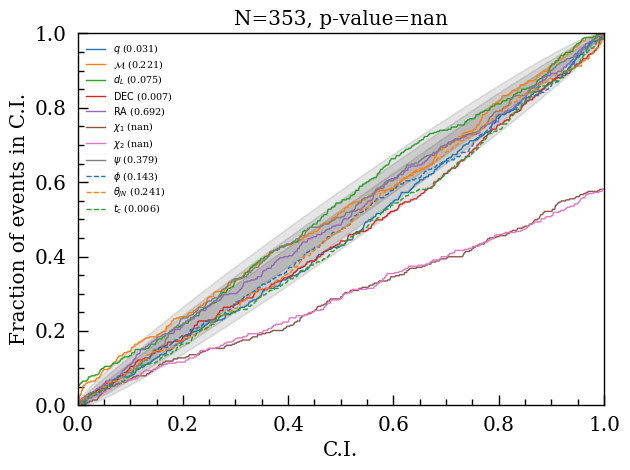

<Figure size 640x480 with 0 Axes>

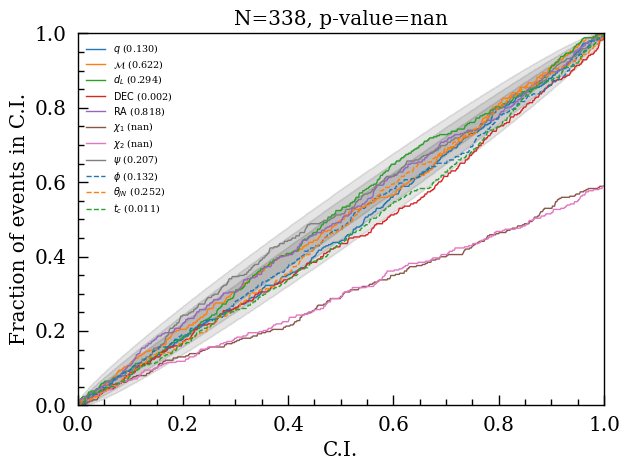

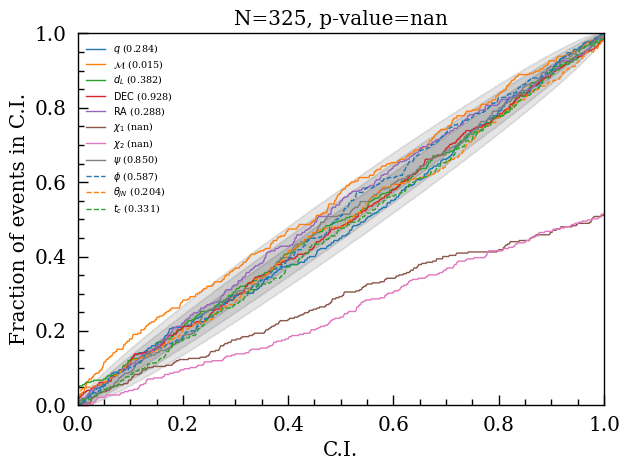

<Figure size 640x480 with 0 Axes>

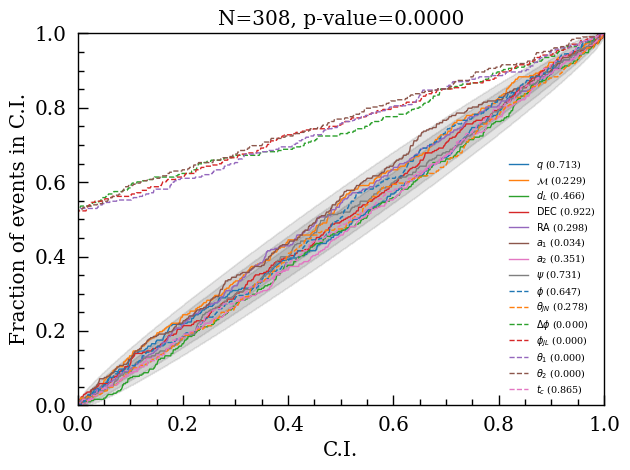

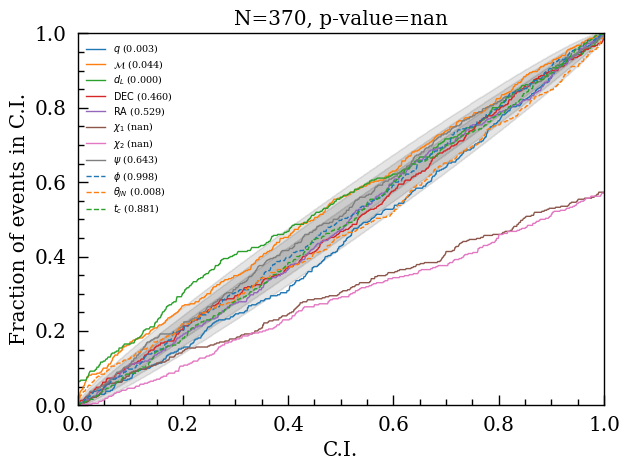

<Figure size 640x480 with 0 Axes>

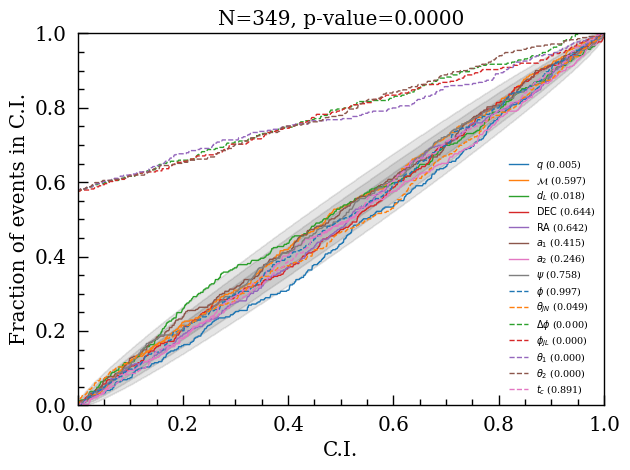

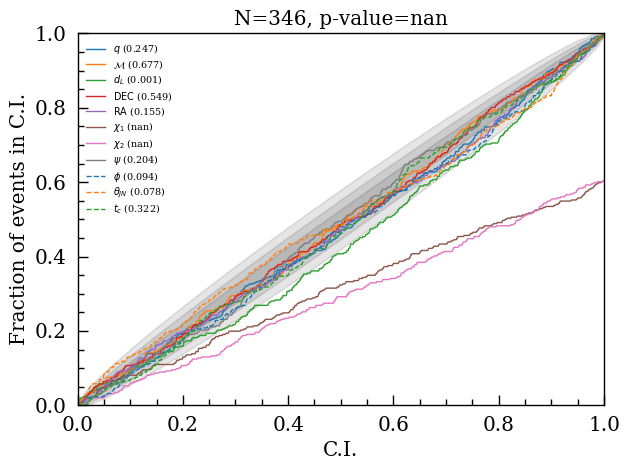

<Figure size 640x480 with 0 Axes>

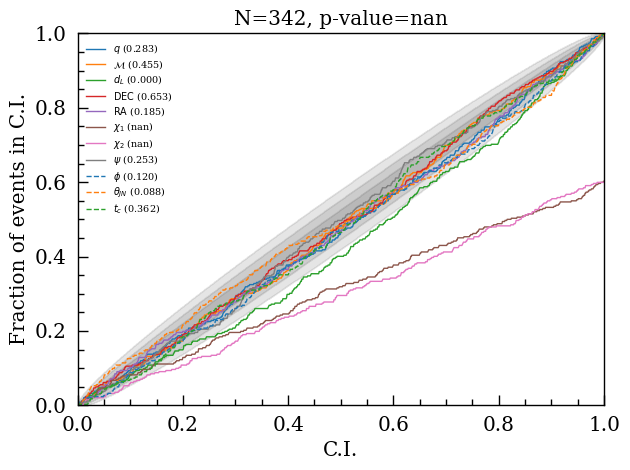

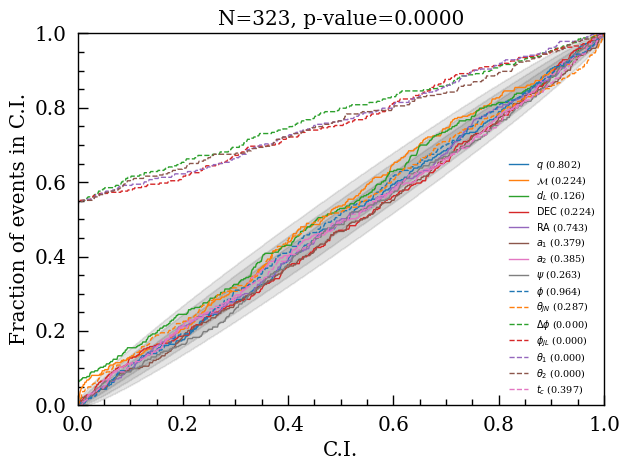

<Figure size 640x480 with 0 Axes>

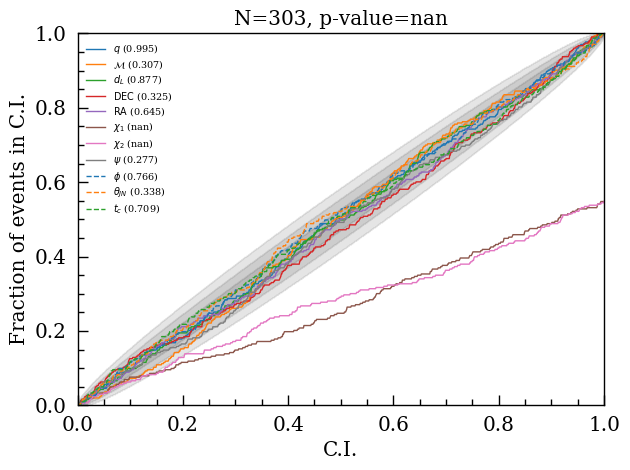

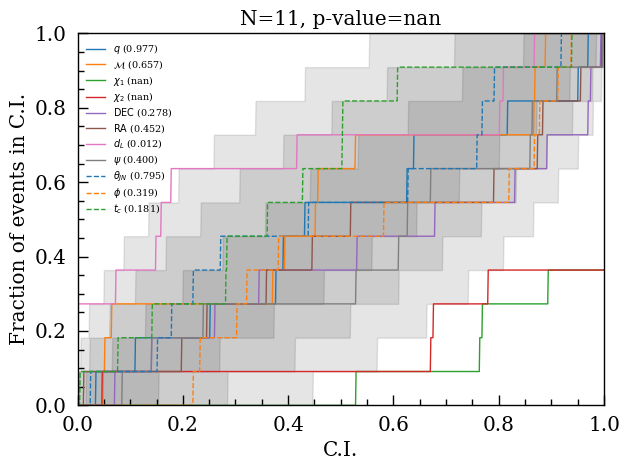

<Figure size 640x480 with 0 Axes>

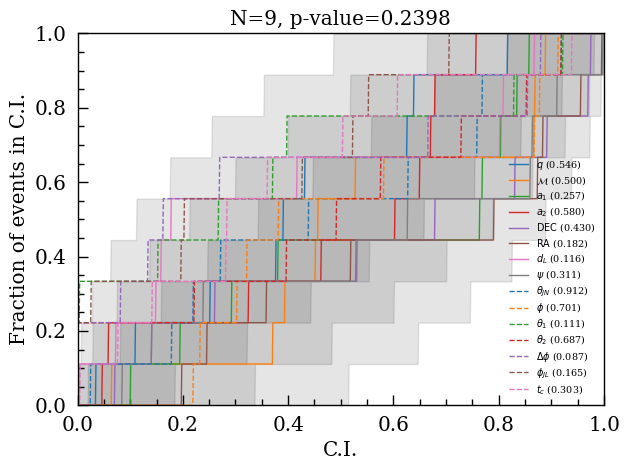

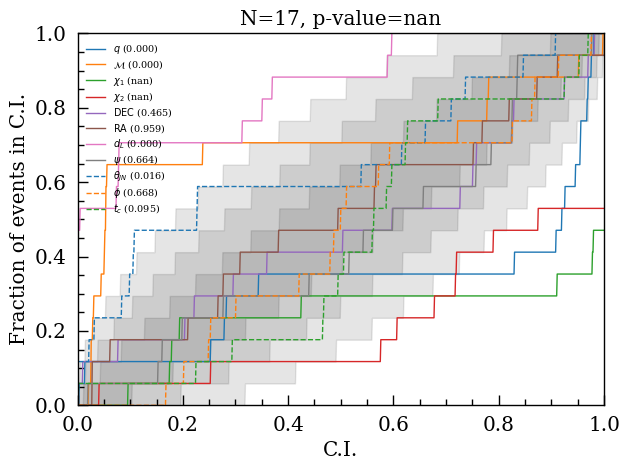

<Figure size 640x480 with 0 Axes>

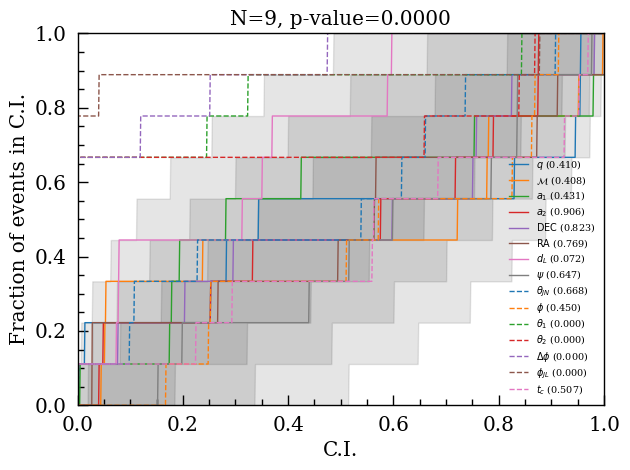

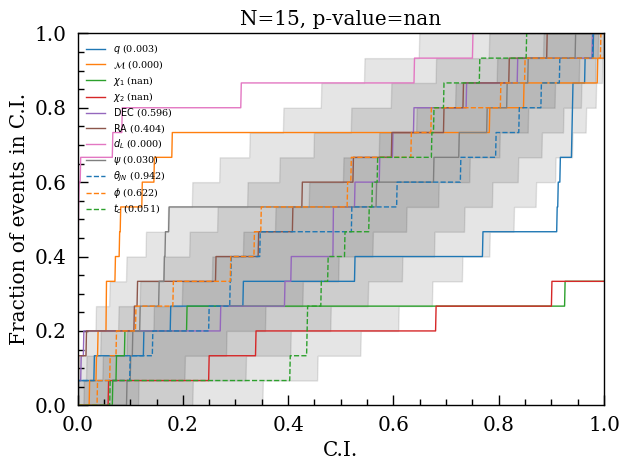

<Figure size 640x480 with 0 Axes>

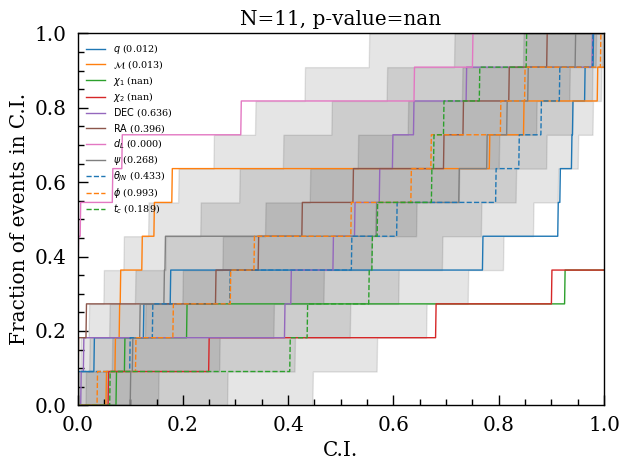

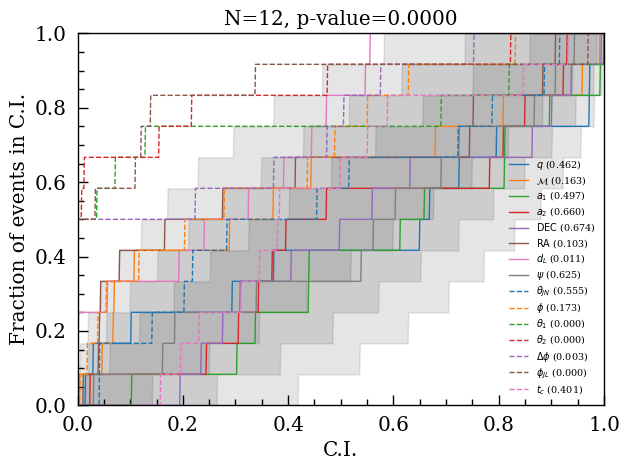

<Figure size 640x480 with 0 Axes>

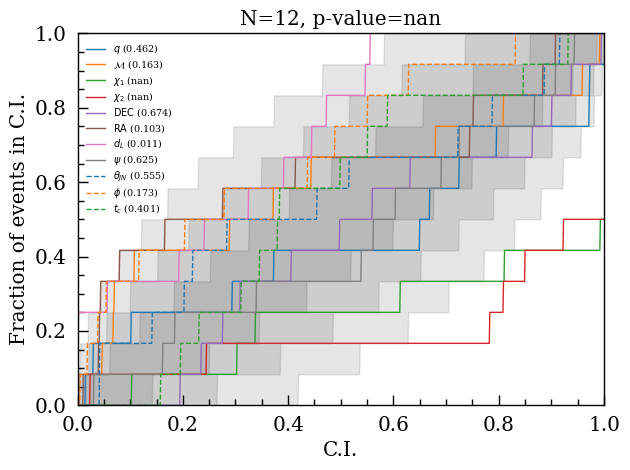

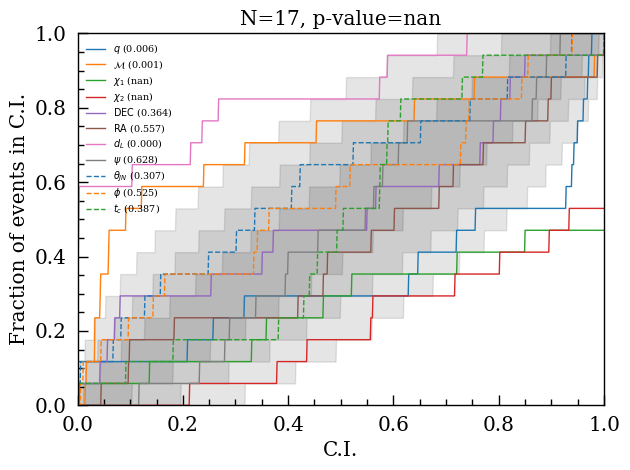

<Figure size 640x480 with 0 Axes>

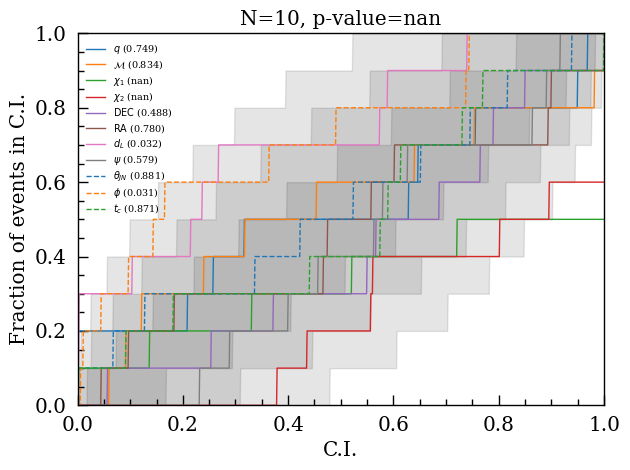

In [5]:
for cType in CBCTypes:

    print(f"Evaluating the {cType} CBCs\n" + "-----" * 15 + "\n")

    for indivCat in individualCatalogs:

        print(f"Evaluating the {cType}s in the {indivCat} catalog\n" + "-----" * 15)

        allEvents, filteredEvents = readEvents(
            baseCatalog, indivCat, cosmo_ready=True, cosmo_cut=10, types=cType
        )

        if makeInitFigs:
            makePP_plot(
                filteredEvents, fname=f"./figures/pp_{indivCat}_{cType}_masked.png"
            )
            makePP_plot(
                filteredEvents,
                fname=f"./figures/pp_{indivCat}_{cType}_masked_keys.png",
                keys=["luminosity_distance", "chirp_mass", "ra", "dec", "mass_ratio"],
            )

            inj, rec, fig, ax = inj_rec_plot(filteredEvents)
            fig.show()
            plt.close()
            plt.clf()

        convergedEvents = rejectNonConverged_Events(
            filteredEvents, inj, rec, frac_diff=2.5
        )

        print(
            f"Number of CBC's after SNR cut and convergence cleaning: {len(convergedEvents)}\n"
        )

        if makeFigs:
            makePP_plot(
                convergedEvents, fname=f"./figures/pp_{indivCat}_{cType}_finalCut.png"
            )
            makePP_plot(
                convergedEvents,
                fname=f"./figures/pp_{indivCat}_{cType}_finalCut_keys.png",
                keys=["luminosity_distance", "chirp_mass", "ra", "dec", "mass_ratio"],
            )
            plt.close()

            inj, rec, fig, ax = inj_rec_plot(convergedEvents)
            fig.show()
            plt.close()

## Let's see which catalogs we can recover without adding more CBCs

In [58]:
bustedBBHCats = ["Uniform,StellarMass", "Uniform,u", "Uniform,Uniform"]
CBCTypes = ["BBH"]

Evaluating the BBH CBCs
---------------------------------------------------------------------------

Evaluating the BBHs in the Uniform,StellarMass catalog
---------------------------------------------------------------------------
Reading from directory Uniform,StellarMass
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/Uniform,StellarMass
Number of events for Uniform,StellarMass: 427
Number of events for Uniform,StellarMass, after SNR filtering: 316
Number of CBC's after SNR cut and convergence cleaning: 301

Evaluating the BBHs in the Uniform,u catalog
---------------------------------------------------------------------------
Reading from directory Uniform,u
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/Uniform,u
Number of events for Uniform,u: 428
Number of events for Uniform,u, after SNR filtering: 314
Number of CBC's after SNR cut and convergence cleaning: 310

Evaluating the BBHs in the Uniform,Uniform catalog
------------------------

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

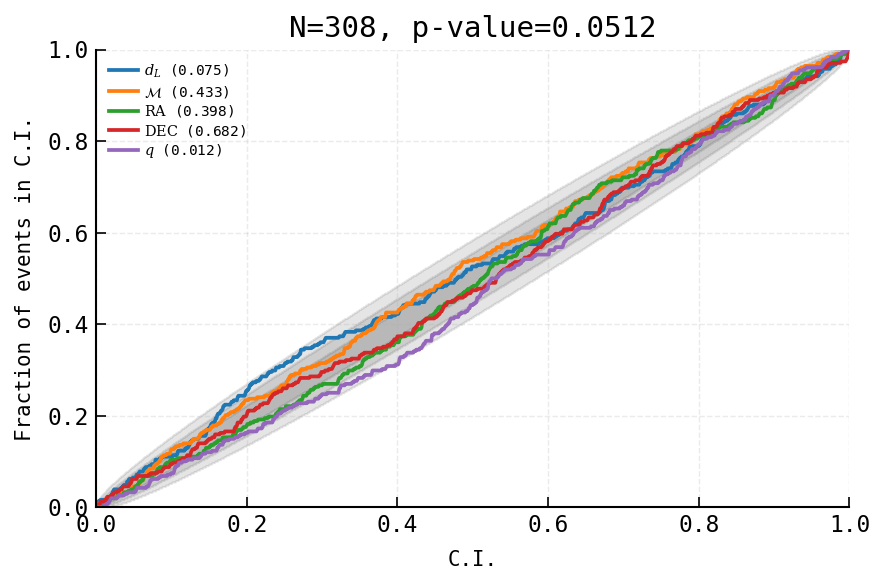

In [59]:
for cType in CBCTypes:

    print(f"Evaluating the {cType} CBCs\n" + "-----" * 15 + "\n")

    for indivCat in bustedBBHCats:

        print(f"Evaluating the {cType}s in the {indivCat} catalog\n" + "-----" * 15)

        allEvents, filteredEvents = readEvents(
            baseCatalog, indivCat, cosmo_ready=True, cosmo_cut=10, types=cType
        )

        if makeInitFigs:
            # makePP_plot(filteredEvents,fname=f"./figures/pp_{indivCat}_{cType}_masked.png")
            # makePP_plot(filteredEvents,fname=f"./figures/pp_{indivCat}_{cType}_masked_keys.png",
            #         keys=["luminosity_distance","chirp_mass","ra","dec","mass_ratio"])

            inj, rec, fig, ax = inj_rec_plot(filteredEvents)
            fig.show()
            plt.close()
            plt.clf()

        convergedEvents = rejectNonConverged_Events(
            filteredEvents, inj, rec, frac_diff=2.5
        )

        print(
            f"Number of CBC's after SNR cut and convergence cleaning: {len(convergedEvents)}\n"
        )
        makePP_plot(
            convergedEvents,
            fname=f"./figures/pp_{indivCat}_{cType}_masked_keys.png",
            keys=["luminosity_distance", "chirp_mass", "ra", "dec", "mass_ratio"],
        )
        ## Do stuff here

In [60]:
def rejectExcessEvents(convergedEvents, target_eventNum=300):
    """
    Iteratively reject events to maximize P–P plot consistency.

    This function reduces a set of converged events to a target size by
    iteratively removing the single event whose exclusion maximizes the
    minimum P–P plot p-value across a fixed set of parameters. At each
    iteration, the function performs a leave-one-out test: for every event,
    it computes the P–P plot statistics for the remaining sample and
    identifies the event whose removal most improves the worst-case
    p-value. That event is then permanently removed from the sample.

    Parameters
    ----------
    convergedEvents : list
        List of converged event objects (e.g., Bilby result-like objects)
        with a ``label`` attribute. The list length must be greater than
        ``target_eventNum``.
    target_eventNum : int, optional
        Desired number of events after rejection. The function will remove
        ``len(convergedEvents) - target_eventNum`` events.
        Default is 300.

    Returns
    -------
    convergedEvents : ndarray
        Array of event objects retained after iterative rejection.
    rejectedEvents : list of str
        Labels of events rejected at each iteration, in the order removed.

    Notes
    -----
    - P–P plot statistics are computed using ``make_pp_plot2`` with the
      parameter set
      ``["luminosity_distance", "chirp_mass", "ra", "dec", "mass_ratio"]``.
    - The optimization criterion is the *minimum* p-value across all tested
      parameters.
    - The procedure is greedy and does not guarantee a globally optimal
      subset.
    - This algorithm scales poorly with the number of events
      (approximately O(N^3) P–P evaluations) and is intended for
      diagnostic or validation studies rather than production-scale use.
    """
    n_iters = len(convergedEvents) - target_eventNum

    rejectedEvents = []

    for it in range(n_iters):
        old_pv = 0
        lbl = ""
        quantity = ""
        for ent in convergedEvents:
            subMsk = [x != ent for x in convergedEvents]
            subList = np.array(convergedEvents)[subMsk]
            pv = make_pp_plot2(
                subList,
                fname=None,
                keys=["luminosity_distance", "chirp_mass", "ra", "dec", "mass_ratio"],
            )

            if min(pv[1]) > old_pv:
                old_pv = min(pv[1])
                quantity = pv[2][np.argmin(pv[1])]
                lbl = ent.label
        print(
            f"For iteration {it}, individual p-value is maximized when {lbl} is excluded"
        )
        rejectedEvents.append(lbl)
        newListMsk = [x.label != lbl for x in convergedEvents]
        convergedEvents = np.array(convergedEvents)[newListMsk]

    return convergedEvents, rejectedEvents

In [61]:
%%time
convergedEvents, rejectedEvents = rejectExcessEvents(convergedEvents)

For iteration 0, individual p-value is maximized when UniformParent,UniformWeight_aligned_BBH_107_data0_0_analysis_H1L1V1 is excluded
For iteration 1, individual p-value is maximized when UniformParent,UniformWeight_precessing_BBH_27_secondpass_data0_0_analysis_H1L1V1 is excluded
For iteration 2, individual p-value is maximized when UniformParent,UniformWeight_aligned_BBH_16_data0_0_analysis_H1L1V1 is excluded
For iteration 3, individual p-value is maximized when UniformParent,UniformWeight_precessing_BBH_102_data0_0_analysis_H1L1V1 is excluded
For iteration 4, individual p-value is maximized when UniformParent,UniformWeight_precessing_BBH_21_thirdPass_data0_0_analysis_H1L1V1 is excluded
For iteration 5, individual p-value is maximized when UniformParent,UniformWeight_aligned_BBH_52_data0_0_analysis_H1L1V1 is excluded
For iteration 6, individual p-value is maximized when UniformParent,UniformWeight_precessing_BBH_62_data0_0_analysis_H1L1V1 is excluded
For iteration 7, individual p-valu

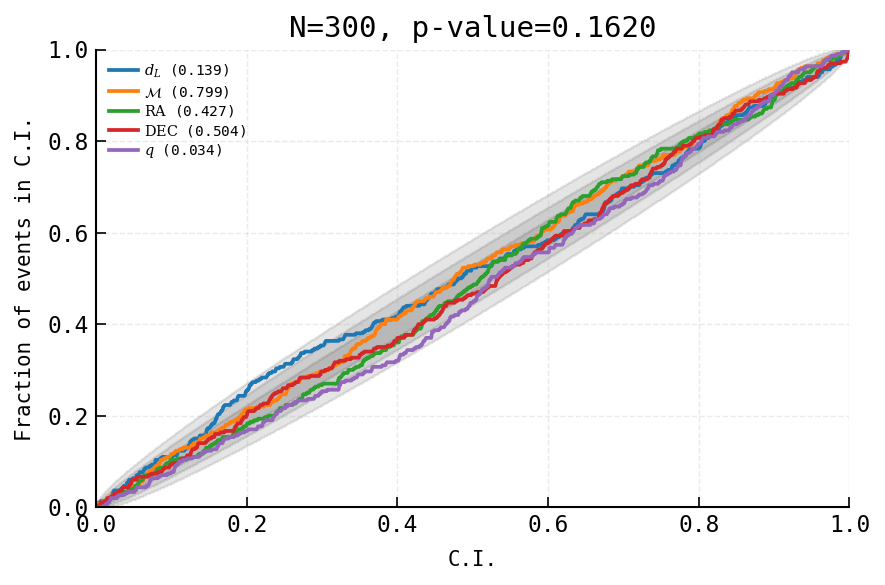

In [62]:
fig, pv = makePP_plot(
    convergedEvents,
    fname=None,
    keys=["luminosity_distance", "chirp_mass", "ra", "dec", "mass_ratio"],
)